In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("zaynena/selfdriving-car-simulator")

print("Path to dataset files:", path)

100%|██████████| 2.24G/2.24G [00:17<00:00, 134MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/zaynena/selfdriving-car-simulator/versions/2


In [2]:
import shutil
src = '/root/.cache/kagglehub/datasets/zaynena/selfdriving-car-simulator/versions/2'
dst = '/content/selfdriving-car-simulator'
shutil.move(src, dst)

'/content/selfdriving-car-simulator'

In [3]:
#explore the data
import pandas as pd
from PIL import Image
from torchvision import transforms

# Load the CSV without a header and specify column names
df = pd.read_csv('/content/selfdriving-car-simulator/dataset/dataset/driving_log.csv', header=None, names=['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed'])

print(df['steering'].iloc[0:1525])
print(df['speed'].iloc[0:1525])
print(df['center'].iloc[0:1525])
#df['steering'].value_counts()

0       0.00
1       0.00
2       0.00
3       0.00
4       0.00
        ... 
1520    0.00
1521   -0.10
1522   -0.25
1523    0.00
1524    0.00
Name: steering, Length: 1525, dtype: float64
0        0.000011
1        0.000007
2        0.000003
3        0.002267
4        0.175589
          ...    
1520    15.496470
1521    15.417630
1522    15.859190
1523    16.019980
1524    16.188450
Name: speed, Length: 1525, dtype: float64
0       Desktop\track1data\IMG\center_2019_04_02_19_25...
1       Desktop\track1data\IMG\center_2019_04_02_19_25...
2       Desktop\track1data\IMG\center_2019_04_02_19_25...
3       Desktop\track1data\IMG\center_2019_04_02_19_25...
4       Desktop\track1data\IMG\center_2019_04_02_19_25...
                              ...                        
1520    Desktop\track1data\IMG\center_2019_04_02_19_27...
1521    Desktop\track1data\IMG\center_2019_04_02_19_27...
1522    Desktop\track1data\IMG\center_2019_04_02_19_27...
1523    Desktop\track1data\IMG\center_2019_04_02_1

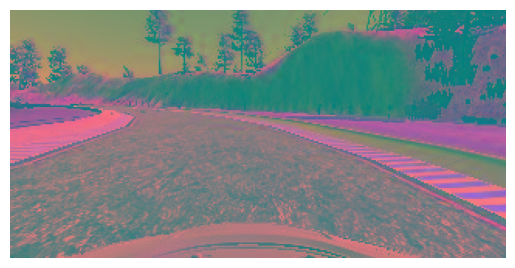

/content/selfdriving-car-simulator/dataset/dataset/IMG/center_2019_04_02_19_25_33_671.jpg


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

testPath = df['center'][0]
cleaned_path = testPath.replace('Desktop\\','').replace('track1data\\', '').replace('IMG\\', '')
newpath = '/content/selfdriving-car-simulator/dataset/dataset/IMG' + '/' + cleaned_path
image = Image.open(newpath)

img = np.array(image)
img_yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

plt.imshow(img_yuv)
plt.axis('off')  # Achsen ausblenden
plt.show()

print(newpath)

In [29]:
#load the dataset
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((66, 200)),
    transforms.CenterCrop((66, 200)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


def processImage(path):
    image = Image.open(newpath)
    #img = np.array(image)
    #img_yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    #img_yuv_pil = Image.fromarray(img_yuv)
    image_processed = transform(image)
    return image_processed

class PigeonPilotDataset(Dataset):
  def __init__(self, dfFile, transform):
    self.dfFile = dfFile

    self.center = self.dfFile['center']
    self.left = self.dfFile['left']
    self.right = self.dfFile['right']
    self.steering = self.dfFile['steering']
    self.throttle = self.dfFile['throttle']
    self.brake = self.dfFile['brake']
    self.speed = self.dfFile['speed']

    self.transform = transform

  def __len__(self):
    return len(self.dfFile)

  def __getitem__(self, idx):
    center, left, right, steering, throttle, brake, speed = self.center[idx], self.left[idx], self.right[idx], self.steering[idx], self.throttle[idx], self.brake[idx], self.speed[idx]

    #bearbeite bilder
    cleaned_path_center = center.replace('Desktop\\','').replace('track1data\\', '').replace('IMG\\', '')
    newpath_center = '/content/selfdriving-car-simulator/dataset/dataset/IMG' + '/' + cleaned_path_center
    processed_image_center = processImage(newpath_center)

    cleaned_path_left = left.replace('Desktop\\','').replace('track1data\\', '').replace('IMG\\', '')
    newpath_left = '/content/selfdriving-car-simulator/dataset/dataset/IMG' + '/' + cleaned_path_left
    processed_image_left = processImage(newpath_left)

    cleaned_path_right = right.replace('Desktop\\','').replace('track1data\\', '').replace('IMG\\', '')
    newpath_right = '/content/selfdriving-car-simulator/dataset/dataset/IMG' + '/' + cleaned_path_right
    processed_image_right = processImage(newpath_right)


    return processed_image_center, processed_image_left, processed_image_right, torch.tensor(steering, dtype=torch.float32)


In [55]:
#hyperparameter
batch_size = 64

In [56]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=False)

train_dataset = PigeonPilotDataset(train_df, transform)
test_dataset = PigeonPilotDataset(test_df, transform)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7c030df2e4d0>,
 <torch.utils.data.dataloader.DataLoader at 0x7c030ce056d0>)

In [57]:
center_img, left_img, right_img, steering = next(iter(train_dataloader))
center_img.shape

torch.Size([64, 3, 66, 200])

In [58]:
#model architecture

class PigeonPilotModel(nn.Module):
  def __init__(self,input_size, hidden_size, output_size):
    super().__init__()
    self.conv_layers = nn.Sequential(
        nn.Conv2d(input_size, 24, 5, stride=2),
        nn.ReLU(),
        nn.Conv2d(24, 36, 5, stride=2),
        nn.ReLU(),
        nn.Conv2d(36, 48, 5, stride=2),
        nn.ReLU(),
        nn.Conv2d(48, 64, 3),
        nn.ReLU(),
        nn.Conv2d(64, 64, 3),
        #nn.Dropout(0.5)
    )

    self.linear_layers = nn.Sequential(
        nn.Linear(64 * 18, 100),
        nn.Linear(100, 50),
        nn.Linear(50, output_size)
    )

  def forward(self, x):
    out = self.conv_layers(x)
    out = out.flatten(1)
    fc_output = self.linear_layers(out)
    return fc_output

In [59]:
#make model and test
if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"

pigeonPilotModel = PigeonPilotModel(3, 10, 1).to(device)

In [60]:
center_img, left_img, right_img, steering = next(iter(train_dataloader))
center_img, left_img, right_img, steering = center_img.to(device), left_img.to(device), right_img.to(device), steering.to(device)

output = pigeonPilotModel(center_img)
steering, output
#output.dtype
#output

(tensor([ 0.2000,  0.0000,  0.0000,  0.0000, -0.1000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.8500,  0.0000,  0.1000,  0.2500,  0.0000,  0.0000,  0.0000,
          0.2000,  0.0000,  0.0000,  0.0000, -0.3500,  0.0000,  0.0000, -0.1000,
          0.0000,  0.0000,  0.0000, -0.9500, -0.1000,  0.0000,  0.0000,  0.8000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.7500,  0.0000,  0.9500,
         -0.1000,  0.0000,  0.3000,  0.7500, -0.6000,  0.0000,  0.0500,  0.1000,
          0.0000,  0.0000,  0.0000,  0.0000, -0.3000,  0.0000,  0.0000,  0.0000,
          0.0000, -0.4500, -0.1000, -0.6500,  0.0000,  0.0000,  0.0000,  0.2500],
        device='cuda:0'),
 tensor([[0.0203],
         [0.0203],
         [0.0203],
         [0.0203],
         [0.0203],
         [0.0203],
         [0.0203],
         [0.0203],
         [0.0203],
         [0.0203],
         [0.0203],
         [0.0203],
         [0.0203],
         [0.0203],
         [0.0203],
         [0.0203],
         [0.0203],
  

In [61]:
#optimizer loss usw
lr = 1e-4
weight_decay = 1e-5
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(pigeonPilotModel.parameters(), lr=0.0001)

In [ ]:
from torch.optim.lr_scheduler import MultiStepLR
#scheduler = MultiStepLR(optimizer, milestones=[30, 50], gamma=0.1)

In [ ]:
#training code
epochs = 10

for epoch in range(epochs):
  pigeonPilotModel.train()
  total_loss = 0
  for center_img, left_img, right_img, steering in train_dataloader:
    center_img, left_img, right_img, steering = center_img.to(device), left_img.to(device), right_img.to(device), steering.to(device)

    output = pigeonPilotModel(center_img)
    y_true = steering.unsqueeze(1)
    loss = loss_fn(output, y_true)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    #print(loss.item())

  print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_dataloader):.4f}")

Epoch 1/10, Loss: 0.1376
Epoch 2/10, Loss: 0.1376
Epoch 3/10, Loss: 0.1375
Epoch 4/10, Loss: 0.1375


In [28]:
torch.save(pigeonPilotModel.state_dict(), "pigeonPilot1.pth")